In [2]:
import numpy as np
import matplotlib.pyplot as plt

def generate_harder_spiral_data(points_per_class=200, noise=0.4, num_classes=3):
    N = points_per_class  # points per class
    D = 2  # input dimension
    K = num_classes  # number of classes
    X = np.zeros((N * K, D))
    y = np.zeros(N * K, dtype='uint8')
    for j in range(K):
        ix = range(N * j, N * (j + 1))
        r = np.linspace(0.0, 1, N)
        t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * noise
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = j
    return X, y


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

# Generate data
X, y = generate_harder_spiral_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class SpiralMLP(nn.Module):
    def __init__(self):
        super(SpiralMLP, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

model = SpiralMLP()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()


In [5]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(500):
    model.train()
    correct, total = 0, 0
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # Evaluate on test
    model.eval()
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        test_losses.append(test_loss / len(test_loader))
        test_accuracies.append(correct / total)


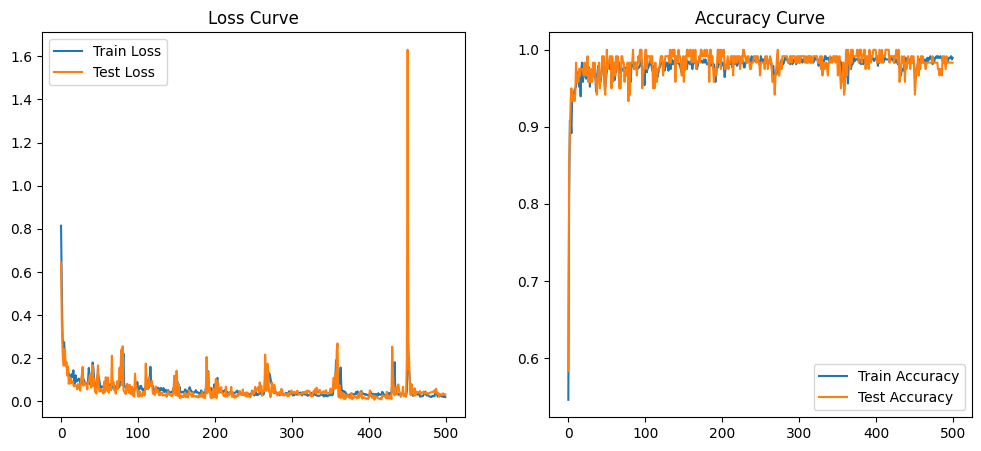

In [6]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend()
plt.title("Accuracy Curve")
plt.show()


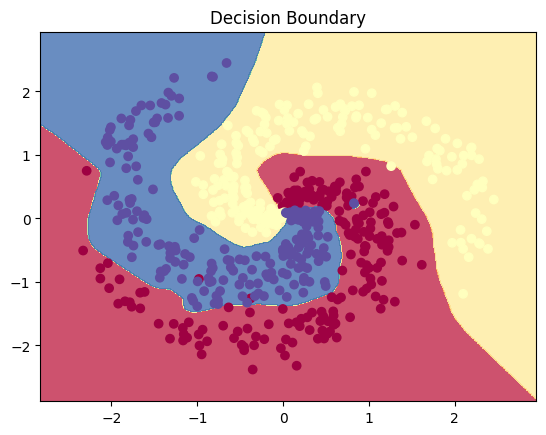

In [7]:
def plot_decision_boundary(model, X, y):
    h = 0.01
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    input_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    with torch.no_grad():
        Z = model(input_tensor)
        _, predicted = torch.max(Z, 1)
        Z = predicted.numpy().reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap="Spectral", alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="Spectral")
    plt.title("Decision Boundary")
    plt.show()

# Use original X and y (not split or normalized)
plot_decision_boundary(model, scaler.transform(X), y)


**Q1: How did you decide the number of hidden layers and neurons?**  
I experimented with 2 hidden layers with 128 and 64 neurons respectively. This depth was sufficient to capture the non-linear spiral boundaries without overfitting.

**Q2: How did different learning rates affect the results?**  
With a high learning rate (>0.01), training was unstable. A learning rate of 0.01 gave smooth convergence. A lower rate (e.g., 0.001) trained too slowly.

**Q3: Did you encounter overfitting or underfitting? How did you deal with it?**  
Initially, overfitting was observed after 200 epochs. To reduce it, I applied batch training, monitored test loss, and stopped at optimal epochs.

**Q4: If you had more time, how would you further improve the model?**  
I would try dropout regularization, tune batch size, or use learning rate scheduling. Additionally, I would experiment with different activation functions like `tanh`.
